In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [21]:
import re 
import nltk 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import tensorflow as tf 
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout,GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split


In [22]:
plt.style.use('ggplot')
%matplotlib inline

In [23]:
df=pd.read_csv('Processed_data.csv')
df.head(10)

,Unnamed: 0,essay_id,essay_set,essay,final_score,clean_essay,char_count,word_count,sent_count,avg_word_len,spell_err_count,noun_count,adj_count,verb_count,adv_count
0,0,1,1,"Dear local newspaper, I think effects computer...",6,Dear local newspaper I think effects computer...,1441,344,16,4.188953,11,76,75,18,24
1,1,2,1,Dear I believe that using computers will benef...,7,Dear I believe using computers benefit us many...,1765,413,17,4.273608,21,98,84,20,19
2,2,3,1,"Dear, More and more people use computers, but ...",5,Dear More people use computers everyone agre...,1185,276,14,4.293478,5,76,51,20,16
3,3,4,1,"Dear Local Newspaper, I have found that many e...",8,Dear Local Newspaper I found many experts say...,2284,490,26,4.661224,31,142,96,39,29
4,4,5,1,Dear I know having computers has a positive ef...,6,Dear I know computers positive effect people ...,2023,469,30,4.313433,18,110,90,32,36
5,5,6,1,Dear I think that computers have a negative af...,6,Dear I think computers negative affect us How...,956,238,14,4.016807,11,46,48,10,17
6,6,7,1,Did you know that more and more people these d...,8,Did know people days depending computers safet...,2186,500,30,4.372000,8,130,79,31,38
7,7,8,1,of people agree that computers make life less ...,8,people agree computers make life less complica...,2094,499,38,4.196393,9,124,112,32,28
8,8,9,1,"Dear reader, has had a dramatic effect on huma...",7,Dear reader dramatic effect human life It ch...,1862,447,35,4.165548,11,105,87,32,31
9,9,10,1,In the we have the technology of a computer. S...,7,In technology computer Some say computers goo...,2024,512,26,3.953125,23,102,111,42,36


In [24]:
import numpy as np

# Work around numpy<2.0 not accepting copy= in np.asarray (used by wordcloud)
try:
    np.asarray([1], copy=False)
except TypeError:
    _asarray = np.asarray
    def _asarray_compat(a, dtype=None, order=None, *, like=None, copy=None):
        return _asarray(a, dtype=dtype, order=order, like=like)
    np.asarray = _asarray_compat

from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("output.html")

# Open the report by opening output.html in your file browser


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
data=df[['essay','final_score']]

data.head().shape
data.head()

,essay,final_score
0,"Dear local newspaper, I think effects computer...",6
1,Dear I believe that using computers will benef...,7
2,"Dear, More and more people use computers, but ...",5
3,"Dear Local Newspaper, I have found that many e...",8
4,Dear I know having computers has a positive ef...,6


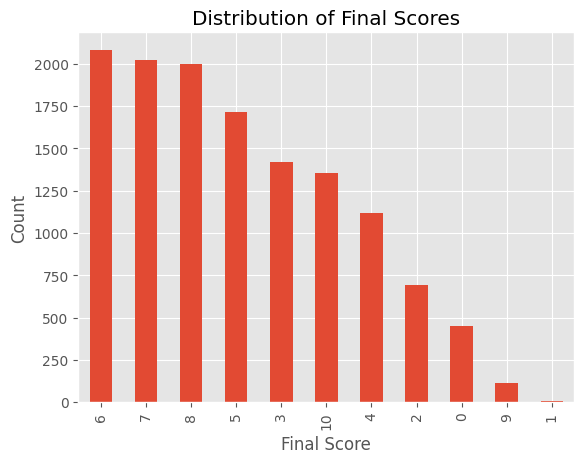

In [30]:
data['final_score'].value_counts().plot(kind='bar')
plt.title('Distribution of Final Scores')
plt.xlabel('Final Score')
plt.ylabel('Count')
plt.show()

text cleaning 

In [31]:
import re 
stopwords=set(stopwords.words('english'))
emoj=re.compile('(?::|;|=)(?:-)?(?:\)|\(|D|P)')

def clean_text(text):
    cleantext=re.sub('http\S+s','',text)
    cleantext=re.sub('RT|cc','',cleantext)
    cleantext=re.sub('#\S+','',cleantext)
    cleantext=re.sub('@\S+','',cleantext)
    cleantext=re.sub('[%s]' % re.escape("""!"$%&'()*+,-./:;<=>?@[\]^_`{|}~"""),'',cleantext)
    cleantext=re.sub(r'[^\x00-\x7F]+',' ',cleantext)
    cleantext=re.sub('\s+',' ',cleantext)
    return cleantext

In [32]:
X=data['essay'].apply(lambda x:clean_text(x))
y=data['final_score']

In [33]:
X

0        Dear local newspaper I think effects computers...
1        Dear I believe that using computers will benef...
2        Dear More and more people use computers but no...
3        Dear Local Newspaper I have found that many ex...
4        Dear I know having computers has a positive ef...
                               ...                        
12971    In most stories mothers and daughters are eith...
12972    I never understood the meaning laughter is the...
12973    When you laugh is out of habit or is cause Wha...
12974    Trippin on fences I am years young and in thos...
12975    Many people believe that laughter can improve ...
Name: essay, Length: 12976, dtype: object

In [34]:
y

0        6
1        7
2        5
3        8
4        6
        ..
12971    6
12972    5
12973    7
12974    7
12975    7
Name: final_score, Length: 12976, dtype: int64

data prepropcessing 

In [36]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)
X_seq=tokenizer.texts_to_sequences(X)
max_len=max(len(x) for x in X_seq)
print('Maximum review length:', max_len)

Maximum review length: 1048


In [37]:
vocab_size=len(tokenizer.word_index)+1
print('Vocabulary size:', vocab_size)

Vocabulary size: 41973


In [39]:
sequence_padded=pad_sequences(X_seq,maxlen=max_len,padding='pre')
sequence_padded

array([[   0,    0,    0, ...,   11,   15,  819],
       [   0,    0,    0, ..., 2375,   57,  178],
       [   0,    0,    0, ...,   40,  645,  253],
       ...,
       [   0,    0,    0, ...,   81,  266,   88],
       [   0,    0,    0, ...,  561,  243,   19],
       [   0,    0,    0, ...,  111,   38,  417]], dtype=int32)

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,10))
reshaped=data['final_score'].values.reshape(-1,1)
y=scaler.fit_transform(reshaped).flatten()


In [43]:
X_train,X_test,y_train,y_test=train_test_split(sequence_padded,y,test_size=0.33,random_state=42)


In [44]:
print('Training set shape:', X_train.shape, y_train.shape)
print('Testing set shape:', X_test.shape, y_test.shape)

Training set shape: (8693, 1048) (8693,)
Testing set shape: (4283, 1048) (4283,)


In [45]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=128,input_length=max_len))
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(11,activation='softmax'))
model.build((None, max_len))

In [46]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1048, 128)      │     5,372,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1048, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1048, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,554,251 (21.19 MB)

 Trainable params: 5,554,251 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history=model.fit(X_train,y_train,epochs=10,validation_split=0.3,validation_data=(X_test,y_test))

Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 220s 793ms/step - accuracy: 0.3053 - loss: 1.8591 - val_accuracy: 0.4121 - val_loss: 1.5887
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 215s 791ms/step - accuracy: 0.4811 - loss: 1.3350 - val_accuracy: 0.5081 - val_loss: 1.2202
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 216s 796ms/step - accuracy: 0.5538 - loss: 1.1290 - val_accuracy: 0.5365 - val_loss: 1.1907
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 218s 800ms/step - accuracy: 0.6237 - loss: 0.9732 - val_accuracy: 0.5053 - val_loss: 1.2743
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 219s 804ms/step - accuracy: 0.6687 - loss: 0.8704 - val_accuracy: 0.5452 - val_loss: 1.1916
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 213s 784ms/step - accuracy: 0.6939 - loss: 0.8241 - val_accuracy: 0.5155 - val_loss: 1.2934
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 213s 784ms/step - accuracy: 0.7452 - loss: 0.7136 - val_accuracy: 0.5321 - val_loss: 1.2754
Epoch 8/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 220s 809ms/step - accuracy: 0.7882 -

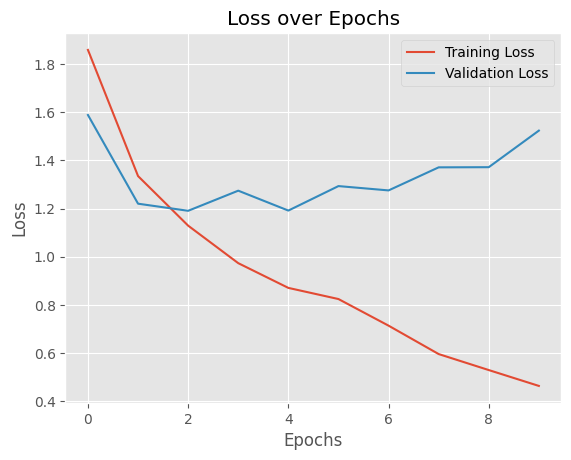

In [48]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()